[0.9987875, 0.0012125, 0.0]
[[9.98787500e-01 1.21250000e-03 0.00000000e+00]
 [9.92834121e-01 3.42935111e-03 3.73652746e-03]
 [9.76425512e-01 9.42223912e-03 1.41522490e-02]
 [9.34348113e-01 2.39687527e-02 4.16831342e-02]
 [8.43538255e-01 5.08762600e-02 1.05585485e-01]
 [7.02321239e-01 7.75843282e-02 2.20094432e-01]
 [5.60356082e-01 7.84128832e-02 3.61231035e-01]
 [4.62754877e-01 5.64047466e-02 4.80840377e-01]
 [4.08915764e-01 3.29386418e-02 5.58145594e-01]
 [3.81909932e-01 1.72417257e-02 6.00848342e-01]
 [3.68845789e-01 8.55202325e-03 6.22602187e-01]
 [3.62613413e-01 4.13356186e-03 6.33253025e-01]
 [3.59657103e-01 1.97349811e-03 6.38369398e-01]
 [3.58258259e-01 9.36738200e-04 6.40805003e-01]
 [3.57597107e-01 4.43409290e-04 6.41959484e-01]]
[  97.          274.34808883  753.77912973 1917.50021899 4070.10080347
 6206.74625843 6273.03065253 4512.37972884 2635.09134782 1379.33805897
  684.1618596   330.68494879  157.87984873   74.93905598   35.47274323]


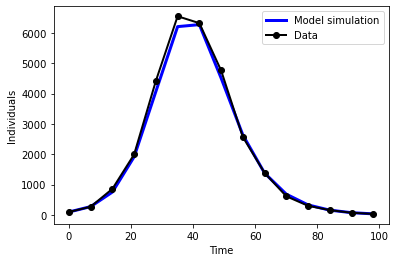

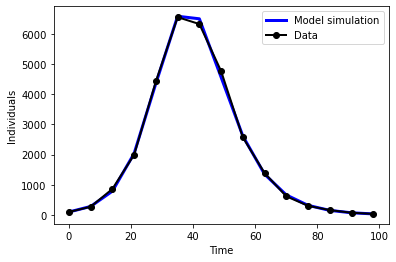

3
[[1.98066299e+10 1.10016690e+10 3.77053476e+04]
 [1.10016690e+10 1.10680375e+10 2.59296580e+04]
 [3.77053476e+04 2.59296580e+04 7.68473201e-02]]


AttributeError: module 'proflike' has no attribute 'proflike'

In [7]:
import import_ipynb
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sir_ode
import sir_cost
import minifim
import proflike

from scipy.integrate import odeint as ode




#### Load Data ####
times = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98]
data = [97, 271, 860, 1995, 4419, 6549, 6321, 4763, 2571, 1385, 615, 302, 159, 72, 34]

#shortened version for seeing how truncated data affects the estimation
#times = times[0:7]
#data = data[0:7]

#### Set initial parameter values and initial states ####
params = [0.4, 0.25, 80000.0]#make sure all the params and inition states are float
paramnames = ['beta', 'gamma', 'k']
ini = sir_ode.x0fcn(params,data)
print (ini)

#### Simulate and plot the model ####
res = ode(sir_ode.model, ini, times, args=(params,))
print (res)
sim_measure = sir_ode.yfcn(res, params)
print (sim_measure)
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()


#### Parameter estimation ####
optimizer = optimize.minimize(sir_cost.NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = sir_ode.x0fcn(paramests, data)

#### Re-simulate and plot the model with the final parameter estimates ####
xest = ode(sir_ode.model, iniests, times, args=(paramests,))
est_measure = sir_ode.yfcn(xest, paramests)
plt.plot(times, est_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

#### Calculate the simplified Fisher Information Matrix (FIM) ####
FIM = minifim.minifisher(times, params, data, delta = 0.001)
print (np.linalg.matrix_rank(FIM)) #calculate rank of FIM
print (FIM)

#### Generate profile likelihoods and confidence bounds ####
threshold = stats.chi2.ppf(0.95,len(paramests))/2.0 + optimizer.fun
perrange = 0.25 #percent range for profile to run across

profiles={}
for i in range(len(paramests)):
	profiles[paramnames[i]] = proflike.proflike(paramests, i, sir_cost.NLL, times, data, perrange=perrange)
	plt.figure()
	plt.scatter(paramests[i], optimizer.fun, marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	plt.plot(profiles[paramnames[i]]['profparam'], profiles[paramnames[i]]['fcnvals'], 'k-', linewidth=2, label='Profile likelihood')
	plt.axhline(y=threshold, ls='--',linewidth=1.0, label='Threshold', color='k')
	plt.xlabel(paramnames[i])
	plt.ylabel('Negative log likelihood')
	plt.legend(scatterpoints = 1)
	paramnames_fit = [ n for n in paramnames if n not in [paramnames[i]]]
	paramests_fit = [v for v in paramests if v not in [paramests[i]]]
	print (paramnames_fit)
	print (paramests_fit)

	#plot parameter relationships
	#for j in range(profiles[paramnames[i]]['fitparam'].shape[1]):
	#	plt.figure()
	#	plt.plot(profiles[paramnames[i]]['profparam'],profiles[paramnames[i]]['fitparam'][:,j],'k-', linewidth=2, label=paramnames_fit[j])
	#	plt.scatter(paramests[i], paramests_fit[j], marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
	#	plt.xlabel(paramnames[i])
	#	plt.ylabel(paramnames_fit[j])
	#	plt.legend(scatterpoints = 1)
print (profiles)
plt.show()